In [1]:
%matplotlib notebook

In [2]:
# loading standard modules
import numpy as np
import matplotlib.pyplot as plt
import maxflow
import math

from scipy import ndimage, signal
from skimage import img_as_ubyte
from skimage.color import rgb2grey
# loading custom module (requires file asg1.py in the same directory as the notebook file)
from asg1 import Figure, GraphCutsPresenter

In [20]:
class MyGraphCuts:
    bgr_value = 0
    obj_value = 1
    none_value = 2
    
    def __init__(self, img):
        self.fig = Figure()
        self.pres = GraphCutsPresenter(img, self)
        self.pres.connect_figure(self.fig)
        
        self.num_rows = img.shape[0]
        self.num_cols = img.shape[1]
        self.img = img
        
        # 4-neighbors graph
        self.neighbor_xs = [0, 1]
        self.neighbor_ys = [1, 0]

        # 8-neighbors graph
        #self.neighbor_xs = [0, 1, 1]
        #self.neighbor_ys = [1, 0, 1]
        self.flip = True

    def run(self):
        self.fig.show()

    def compute_labels(self, seed_mask):
        num_rows = self.num_rows
        num_cols = self.num_cols
        
        neighbor_xs = self.neighbor_xs
        neighbor_ys = self.neighbor_ys
        num_neighbors = len(neighbor_xs)
        img = self.img
        node = 0
        
        g = maxflow.Graph[int](num_rows*num_cols, num_rows*num_cols)
        g.add_nodes(num_rows*num_cols)
        
        # Select a 'good' parameter sigma
        # We select sigma based on the standard intensity difference between pixels
        std_r = np.std(img[:,:,0])
        std_g = np.std(img[:,:,1])
        std_b = np.std(img[:,:,2])
        std_rgb = np.array([std_r, std_g, std_b])
        sigma_sqr = np.sum(np.power(std_rgb, 2))
        
        node_d = {}
        
        # Creating nlink and tlinks
        for i in range(num_rows):
            for j in range(num_cols):
                if (i,j) not in node_d:
                    node_d[(i,j)] = node
                    node += 1
                
                val = seed_mask[i, j]
                
                # Add "prohibitively expensive" terminal edge
                if val == self.bgr_value:
                    g.add_tedge(node_d[(i,j)], 10000000, 0)
                elif val == self.obj_value:
                    g.add_tedge(node_d[(i,j)], 0, 1000000)
               
                # Connect with neighbors
                for k in xrange(num_neighbors):
                    nx = i + neighbor_xs[k]
                    ny = j + neighbor_ys[k]
                    
                    # Check valid coordinates
                    if 0 <= nx and nx < num_cols and 0 <= ny and ny < num_rows:
                        if (nx, ny) not in node_d and node < num_rows*num_cols:
                            node_d[(nx, ny)] = node
                            node += 1
                        intensity_diff = np.sum(np.power(img[i, j] - img[nx, ny],2))
                        weight = np.exp(-(intensity_diff/(2*sigma_sqr)))
                        g.add_edge(node_d[(i, j)], node_d[(nx, ny)], int(weight), int(weight))
         
        # Calculate max flow
        g.maxflow()
        label_mask = np.full((num_rows, num_cols), self.none_value, dtype='uint8')
        
        for key, value in node_d.iteritems():
            label_mask[key[0], key[1]] = g.get_segment(value)
            
        return label_mask

### Notes about the basic graph cut interface:
1. To provide the regional hard constraints (seeds) for object and background segments use left and right mouse clicks (mouse dragging works somewhat too). Use mouse wheel to change the brush size.
2. The seed mask is built by the "GraphCutsPresenter". Each mouse release activates "on_mouse_up" function of the presenter, which asks the linked MyGraphCuts object to "compute_labels" for all pixels
based on the provided seed mask.
3. You should use "PyMaxflow" library (already imported into this notebook if you ran the second cell) to build a weighted graph and to compute a minimum s/t cut defining all pixel labels from the seeds as explain in topic 5.

<IPython.core.display.Javascript object>


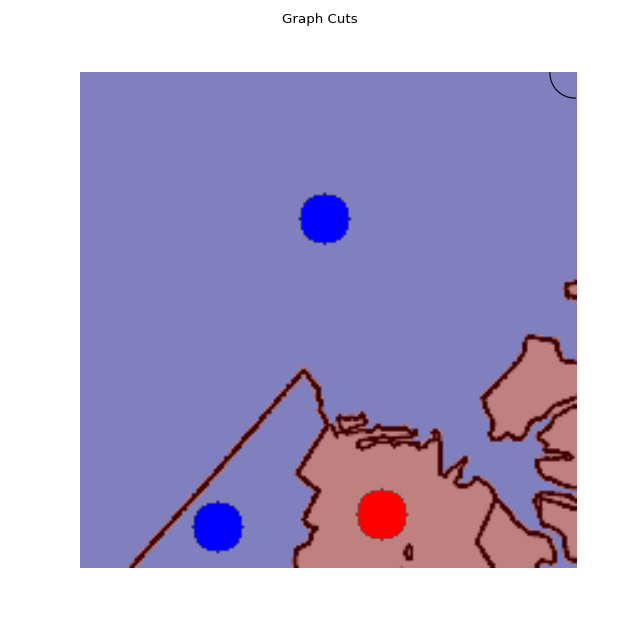

In [21]:
img = plt.imread('images/canada.bmp')
app = MyGraphCuts(img[:200,:200])
app.run()

In [ ]:
img = plt.imread('images/canada.bmp')
app = MyGraphCuts(img[:200,:200])
app.compute_labels(0)

In [ ]:
img = plt.imread('images/canada.bmp')

std_r = np.std(img[:,:,0])
std_g = np.std(img[:,:,1])
std_b = np.std(img[:,:,2])
std_rgb = np.array([std_r, std_g, std_b])
sigma_sqr = np.sum(np.power(std_rgb, 2))
intensity_diff = np.sum(np.power(np.array([255,255,255]) - np.array([0,0,0]),2))
weight = np.exp(-(intensity_diff/(2*sigma_sqr)))

print np.sum(std_rgb)
print 'sigma: ',sigma_sqr
print 'int: ',intensity_diff
print 'full: ', intensity_diff/(2*sigma_sqr)
print 'weight: ', int(weight*10)



In [ ]:
val = True
print val
val = not val
print val

In [ ]:
g = maxflow.Graph[int](2,2)
g.add_nodes(2)
g.add_edge(0, 1, 0, 0)
g.add_tedge(0, 1, 0)
g.add_tedge(1, 0, 1)
print g.maxflow()
print g.get_segment(0)
print g.get_segment(1)